<a href="https://colab.research.google.com/github/dkswndms4782/BoostCamp_AI_Tech/blob/main/optm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/optm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/optm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Regression with Different Optimizers

In [1]:
!pip install matplotlib==3.3.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:[%s]."%(device))

PyTorch version:[1.8.0+cu101].
device:[cuda:0].


### Dataset

In [ ]:
n_data = 10000
x_numpy = -3+6*np.random.rand(n_data,1)
y_numpy = np.exp(-(x_numpy**2))*np.cos(10*x_numpy) + 3e-2*np.random.randn(n_data,1)
plt.figure(figsize=(8,5))
plt.plot(x_numpy,y_numpy,'r.',ms=2)
plt.show()
x_torch = torch.Tensor(x_numpy).to(device)
y_torch = torch.Tensor(y_numpy).to(device)
print ("Done.")

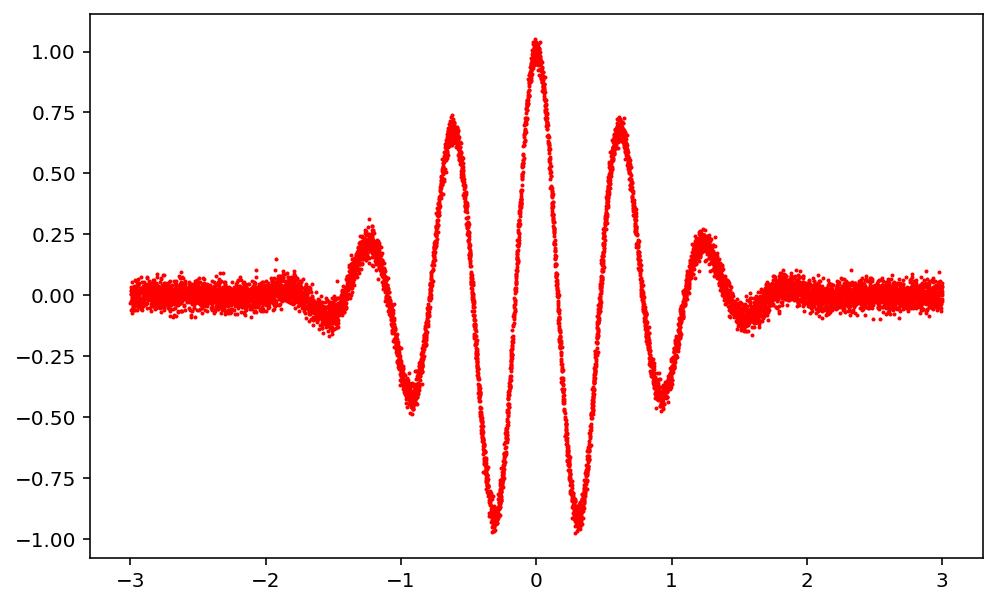

In [3]:
n_data = 10000
# np.random.rand(m,n) : 0~1의 균일붙포 "표준정규분포"난수를 matrix array(m,n)
# np.random.randn(m,n) : 평균 0, 표준편차 1의 "가우시안 표준정규분포" 난수를 matrix array(m,n)
x_numpy = -3 + 6*np.random.rand(n_data, 1)
y_numpy = np.exp(-(x_numpy**2))*np.cos(10*x_numpy) + 3e-2*np.random.randn(n_data, 1)
plt.figure(figsize=(8,5))
plt.plot(x_numpy, y_numpy, 'r.',ms = 2)
# r.이랑 r이랑 뭐가 달라?? 그래프가 너무 달라짐
plt.show()

In [4]:
x_torch = torch.Tensor(x_numpy).to(device)
y_torch = torch.Tensor(y_numpy).to(device)
print("Done.")

Done.


### Define Model

[nn.Sequential] : 
이것은 입력값이 하나일 때, 즉 각 레이어를 데이터가 순차적으로 지나갈 때 사용하면 좋은 방법이라는 것 같다.
간단히 말하자면 여러 nn.Module을 한 컨테이너에 집어넣고 한 번에 돌리는 방법이다.

In [ ]:
class Model(nn.Module):
    def __init__(self,name='mlp',xdim=1,hdims=[16,16],ydim=1):
        super(Model, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdims = hdims
        self.ydim = ydim

        self.layers = []
        prev_hdim = self.xdim
        for hdim in self.hdims:
            self.layers.append(nn.Linear(
                # FILL IN HERE
                prev_hdim, hdim
            ))
            self.layers.append(nn.Tanh())  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)

        self.init_param() # initialize parameters
    
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self,x):
        return self.net(x)

print ("Done.")        

In [5]:
class Model(nn.Module):
  def __init__(self, name = 'mlp', xdim = 1, hdims = [16,16], ydim = 1):
    super(Model, self).__init__()
    self.name = name
    self.xdim = xdim
    self.hdims = hdims
    self.ydim = ydim

    self.layers = []
    prev_hdim = self.xdim
    for hdim in self.hdims:
      self.layers.append(nn.Linear(prev_hdim, hdim))
      self.layers.append(nn.Tanh()) # activation
      prev_hdim = hdim
    self.layers.append(nn.Linear(prev_hdim, self.ydim, bias = True))

    self.net = nn.Sequential()
    for l_idx, layer in enumerate(self.layers):
      layer_name = "%s_%02d"%(type(layer).__name__.lower(), l_idx)
      self.net.add_module(layer_name, layer)
    
  def init_param(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d): # init conv
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.Linear): # init dense
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)
        
  def forward(self, x):
    return self.net(x)

In [ ]:
LEARNING_RATE = 1e-2
# Instantiate models
model_sgd = Model(name='mlp_sgd',xdim=1,hdims=[64,64],ydim=1).to(device)
model_momentum = Model(name='mlp_momentum',xdim=1,hdims=[64,64],ydim=1).to(device)
model_adam = Model(name='mlp_adam',xdim=1,hdims=[64,64],ydim=1).to(device)
# Optimizers
loss = nn.MSELoss()
optm_sgd = optim.SGD(
    model_sgd.parameters(), lr = LEARNING_RATE
)
optm_momentum = optim.SGD( # SGD안에서 모멘텀을 할 수 있어서 SGD 쓴 것. 
                          #인자 momentum에 0이 아닌 값을 주면 momentum, 0을 주면 SGD
    model_momentum.parameters(), lr = LEARNING_RATE, momentum = 0.9
)
optm_adam = optim.Adam(
    model_adam.parameters(), lr = LEARNING_RATE
)
print ("Done.")

In [6]:
LEARNING_RATE = 1e-2
model_sgd = Model(name = "mlp_sgd", xdim = 1, hdims = [64,64], ydim = 1).to(device)
model_momentum = Model(name = "mlp_momentum", xdim = 1, hdims = [64,64], ydim = 1).to(device)
model_adam = Model(name = "mlp_adam", xdim = 1, hdims = [64,64], ydim = 1).to(device)

loss = nn.MSELoss()
optm_sgd = optim.SGD(model_sgd.parameters(), lr = LEARNING_RATE)
optm_momentum = optim.SGD(model_momentum.parameters(), lr = LEARNING_RATE, momentum = 0.9)
optm_adam = optim.Adam(model_adam.parameters(), lr = LEARNING_RATE)

### Check Parameters

 .requires_grad 속성을 True 로 설정하면, 그 tensor에서 이뤄진 모든 연산들을 추적(track)하기 시작합니다. 계산이 완료된 후 .backward() 를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있습니다. 이 Tensor의 변화도는 .grad 속성에 누적됩니다.

In [ ]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(model_sgd.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

In [7]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name, param) in enumerate(model_sgd.named_parameters()):
  if param.requires_grad:
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print(f"{p_idx} name: {param_name} shape:{param_numpy.shape}")
    print(f"    val:{param_numpy.reshape(-1)[:5]}")
print(f"Total number if parameters: {format(n_param, ',d')}")
# format(n_param, ',d') == (4353을 4,353으로 찍어)

0 name: net.linear_00.weight shape:(64, 1)
    val:[-0.156  0.267  0.256  0.583  0.295]
1 name: net.linear_00.bias shape:(64,)
    val:[ 0.386 -0.35  -0.192  0.142 -0.192]
2 name: net.linear_02.weight shape:(64, 64)
    val:[-0.018 -0.022 -0.023  0.113  0.081]
3 name: net.linear_02.bias shape:(64,)
    val:[ 0.018  0.026  0.079  0.083 -0.037]
4 name: net.linear_04.weight shape:(1, 64)
    val:[-0.108  0.034 -0.114  0.098 -0.033]
5 name: net.linear_04.bias shape:(1,)
    val:[0.01]
Total number if parameters: 4,353


### Train

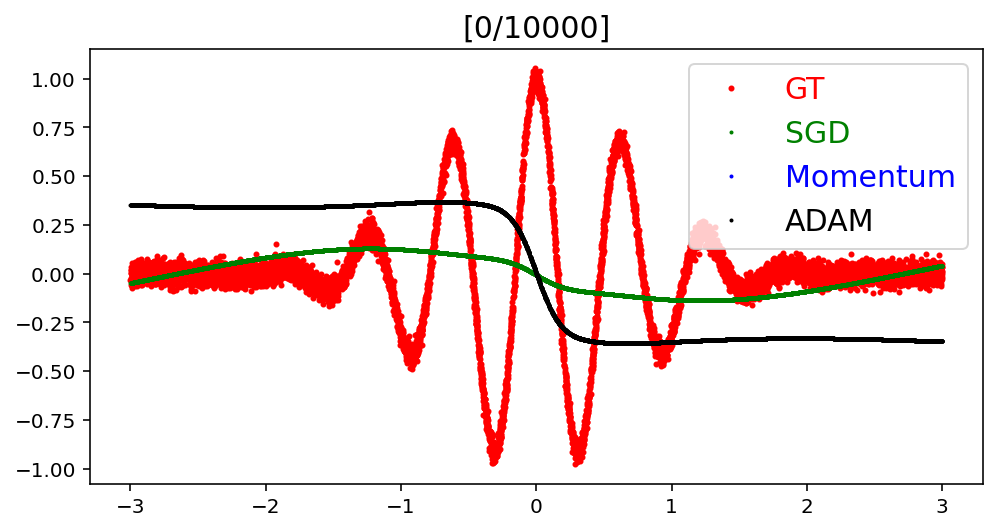

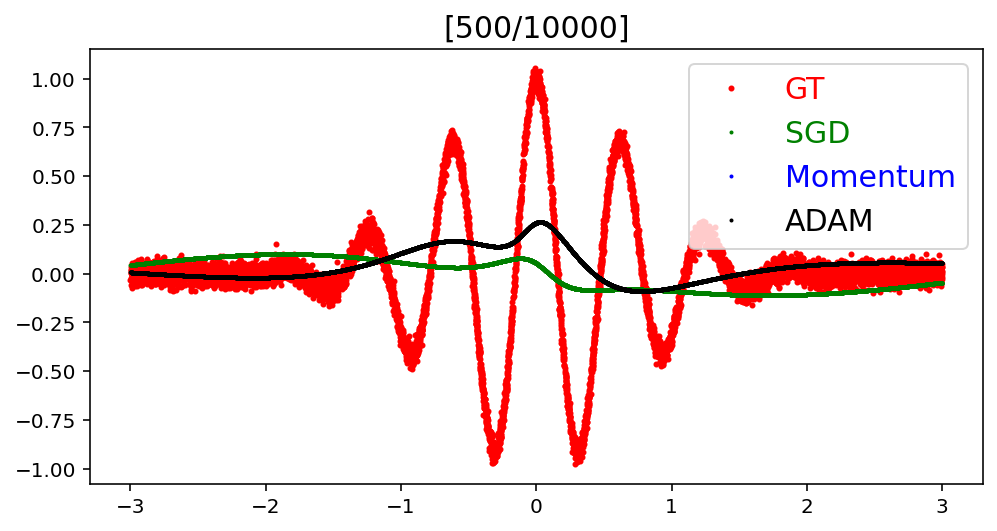

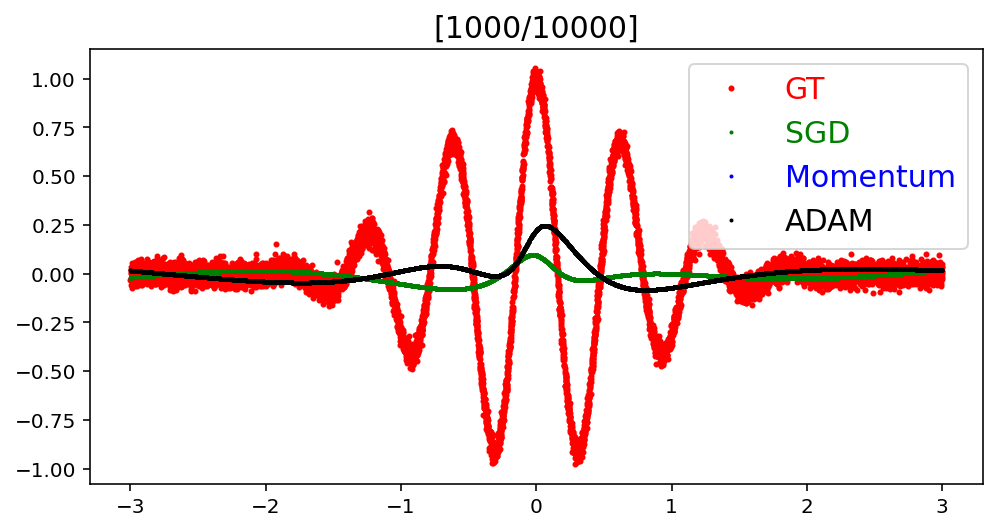

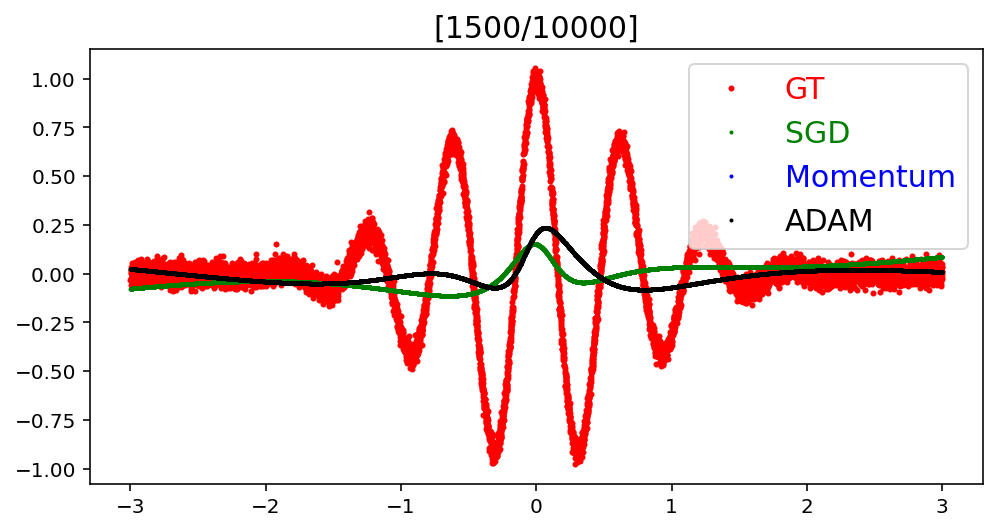

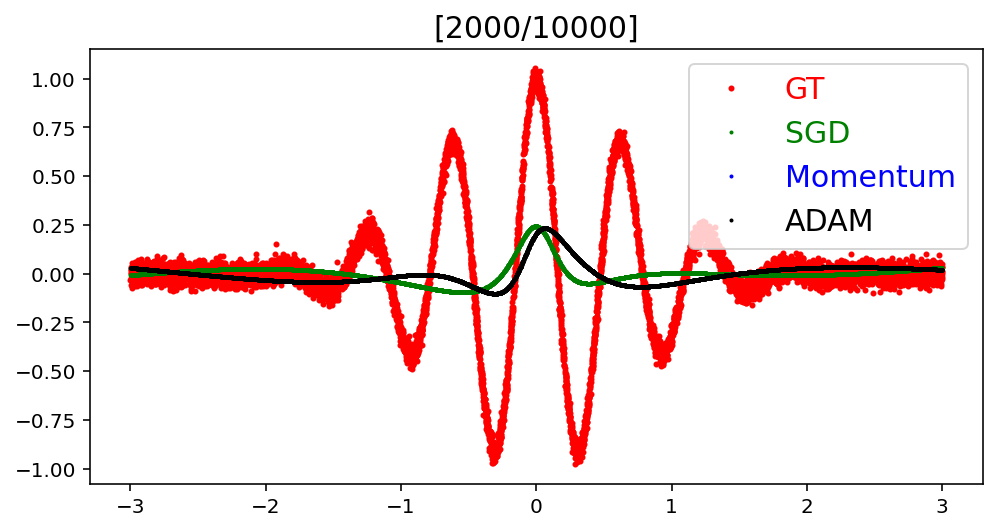

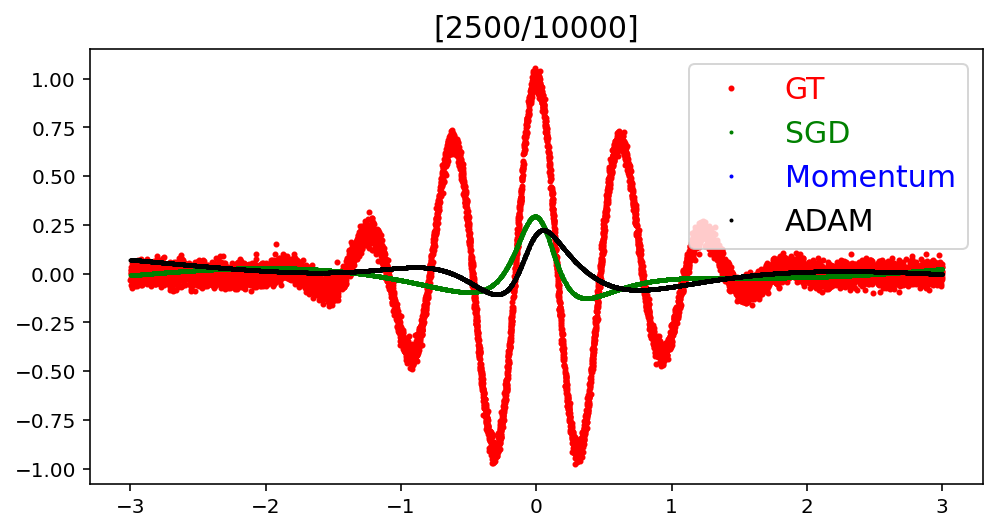

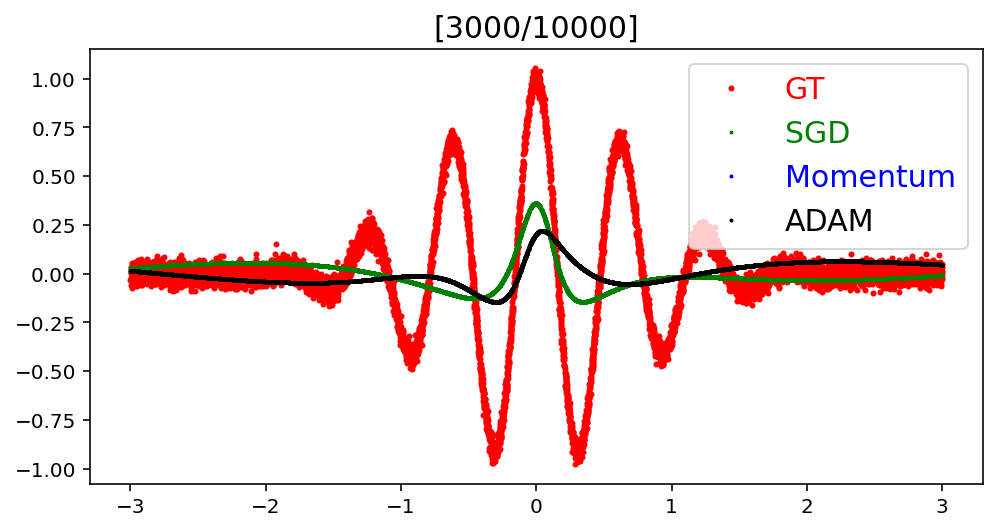

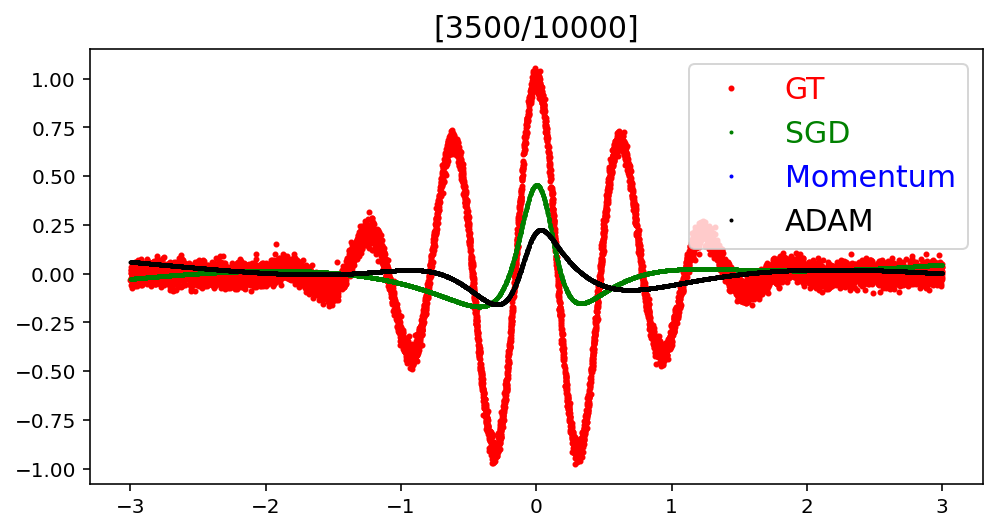

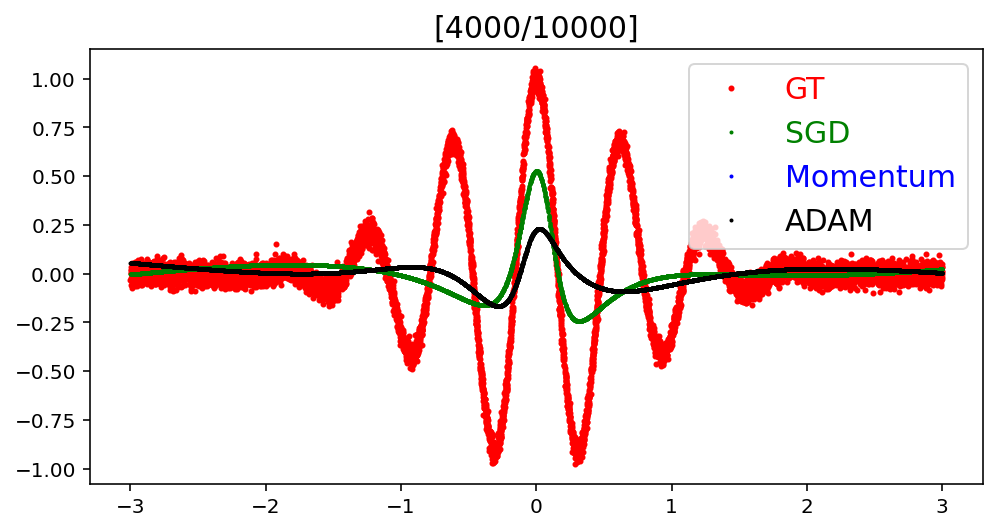

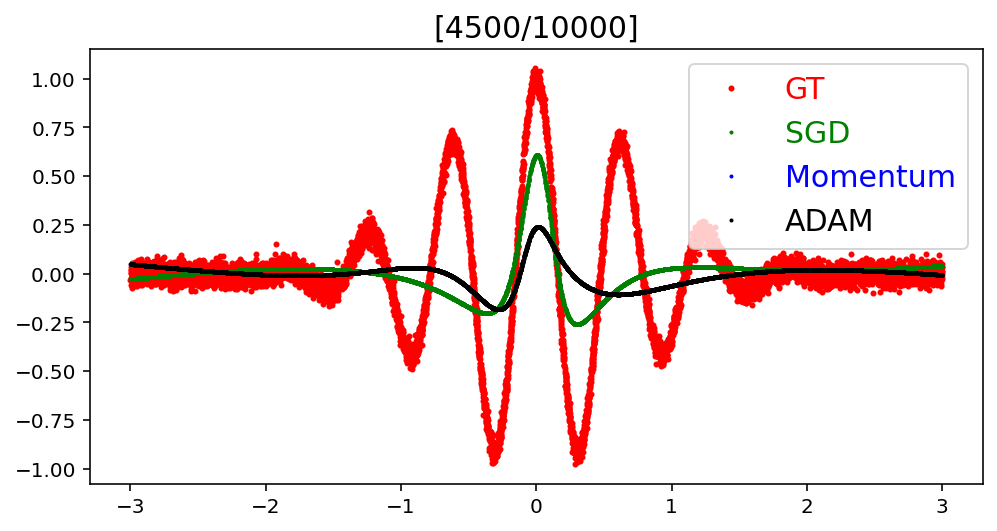

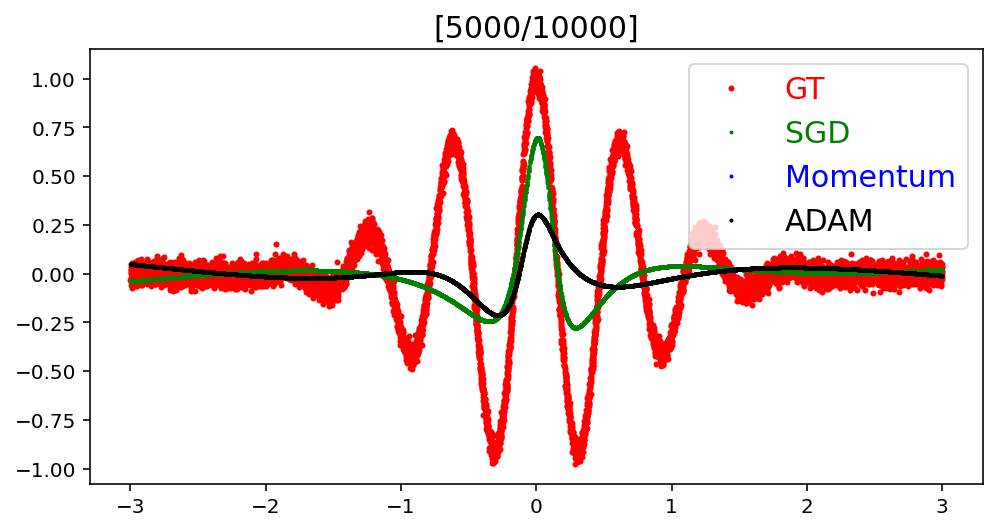

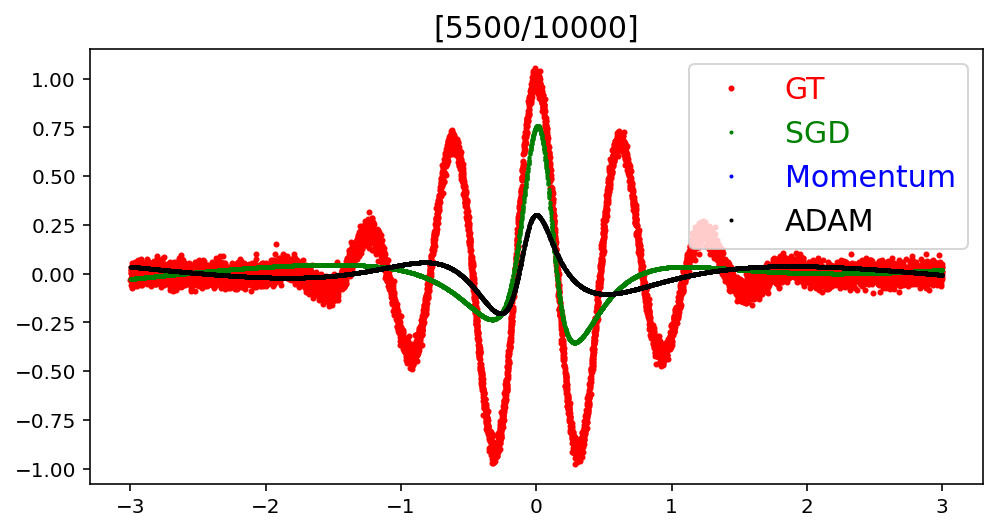

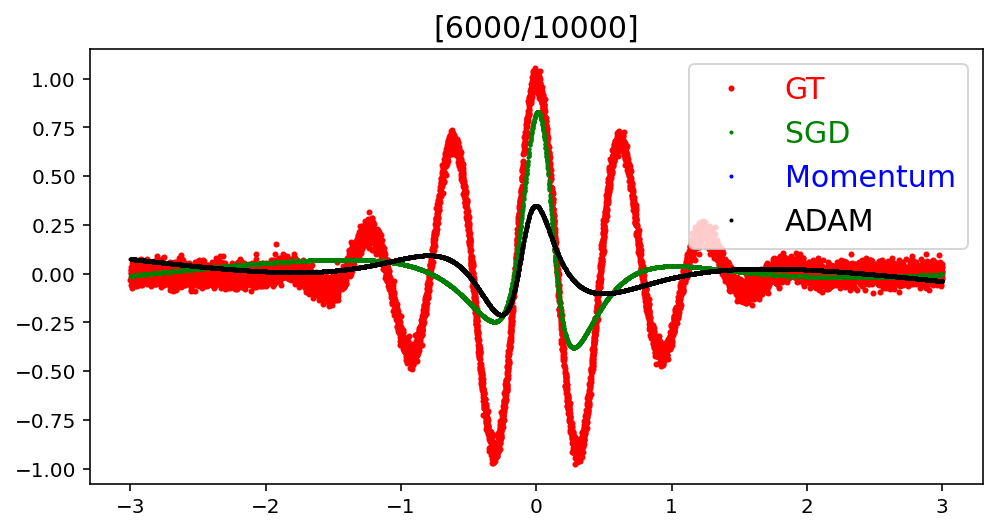

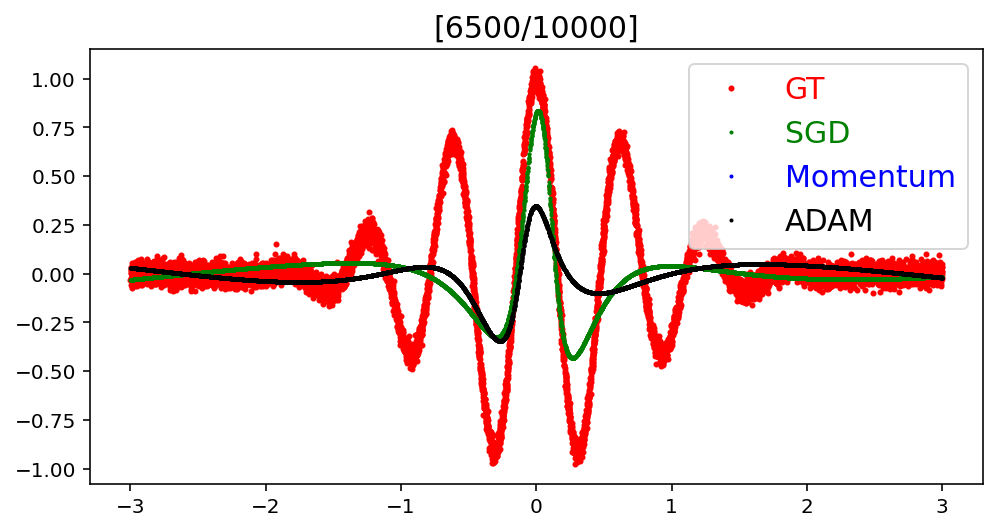

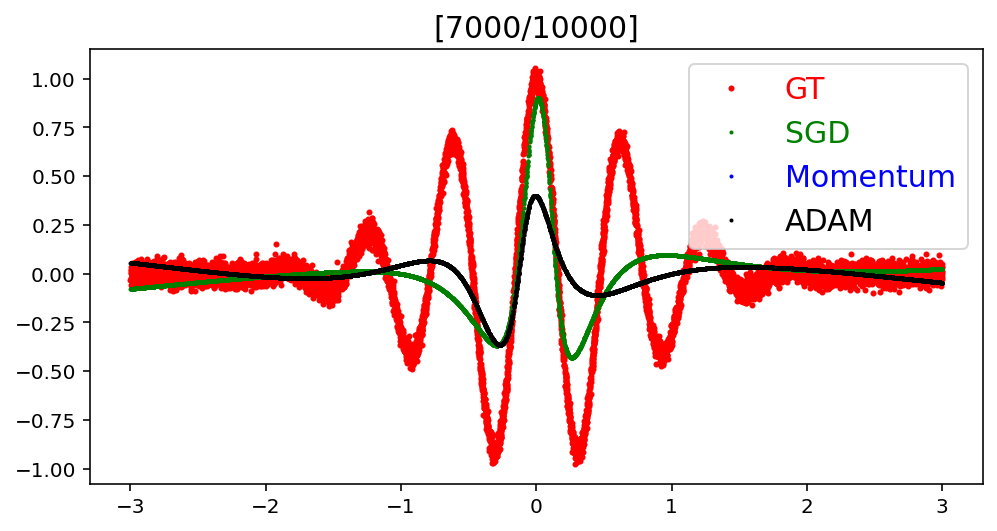

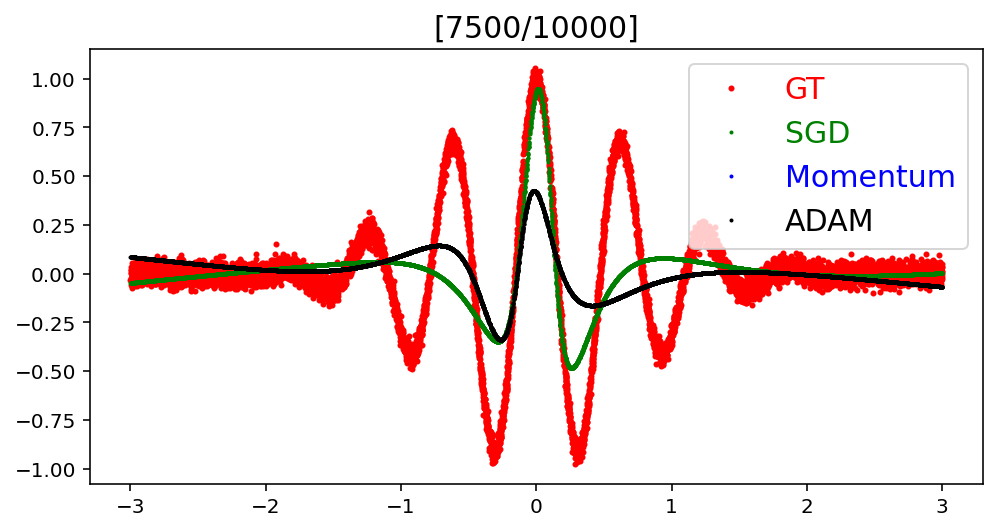

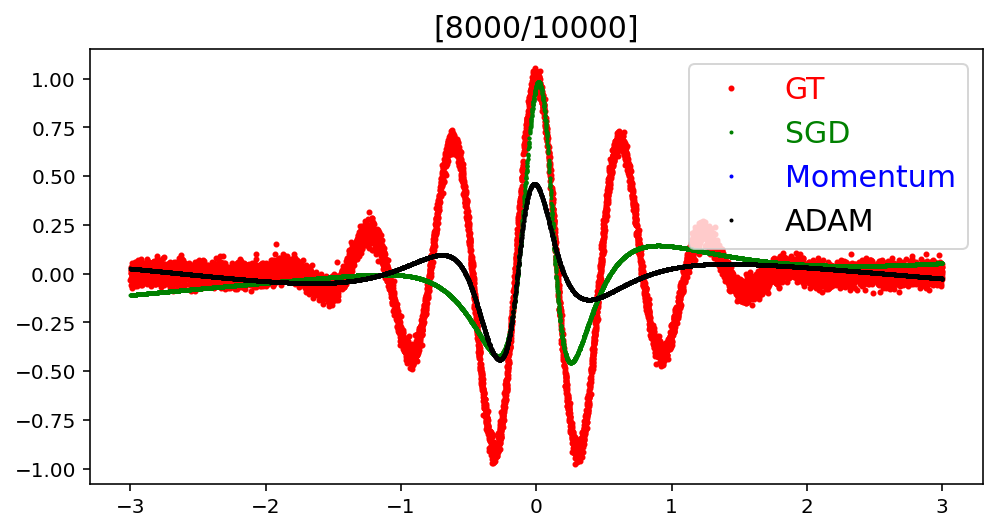

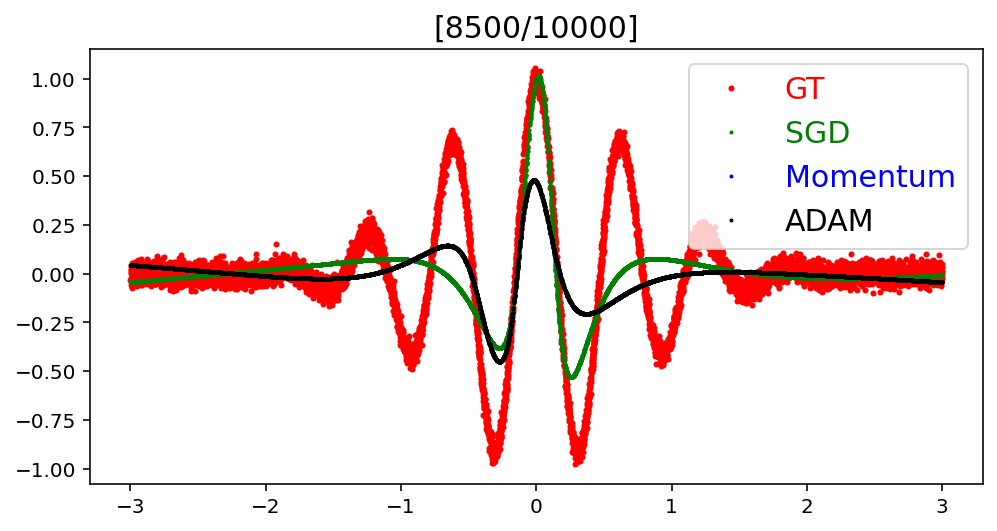

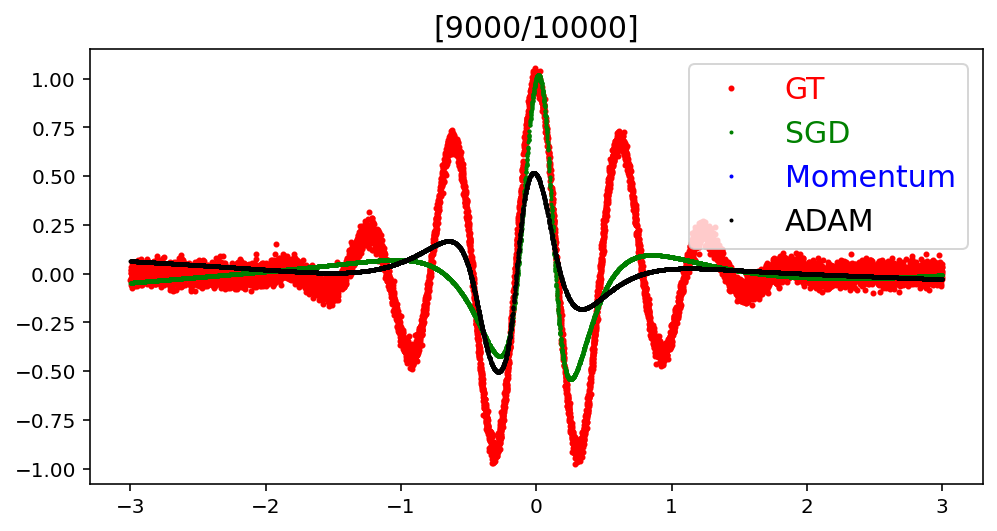

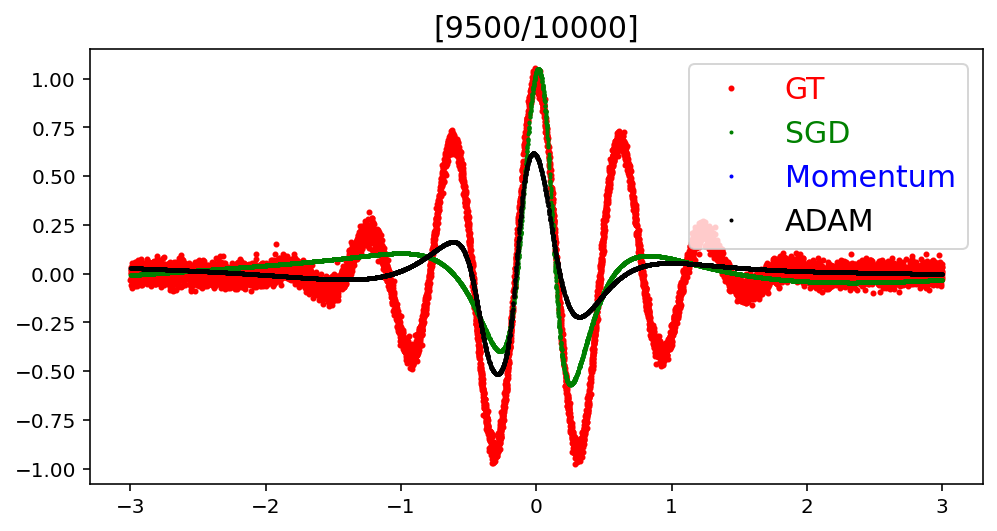

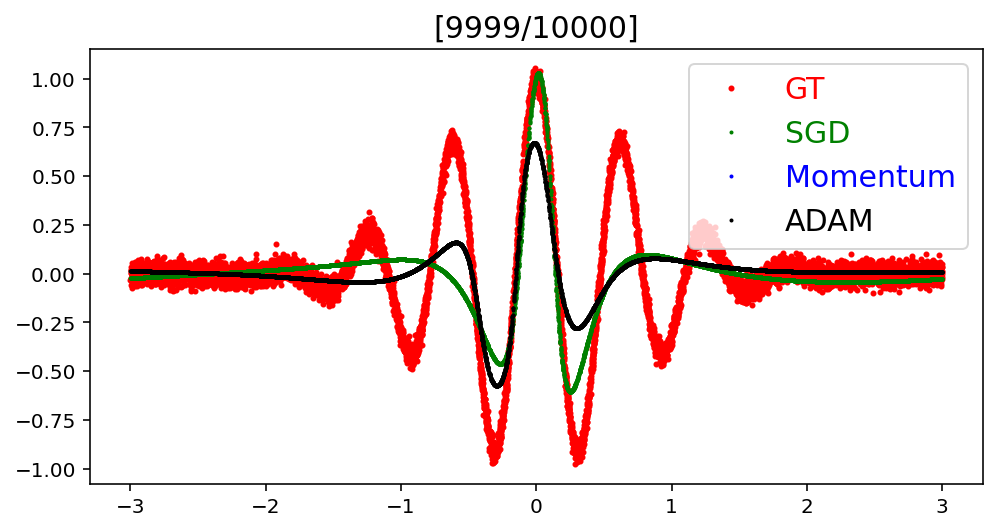

Done.


In [9]:
MAX_ITER,BATCH_SIZE,PLOT_EVERY = 1e4,64,500

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train()
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)):
    r_idx = np.random.permutation(n_data)[:BATCH_SIZE]
    batch_x,batch_y = x_torch[r_idx],y_torch[r_idx]
    
    # Update with Adam
    y_pred_adam = model_adam.forward(batch_x)
    loss_adam = loss(y_pred_adam,batch_y)
    optm_adam.zero_grad()
    loss_adam.backward()
    optm_adam.step()

    # Update with Momentum
    y_pred_momentum = model_momentum.forward(batch_x)
    loss_momentum = loss(y_pred_momentum,batch_y)
    optm_momentum.zero_grad()
    loss_momentum.backward()
    optm_momentum.step()

    # Update with SGD
    y_pred_sgd = model_sgd.forward(batch_x)
    loss_sgd = loss(y_pred_sgd,batch_y)
    optm_sgd.zero_grad()
    loss_sgd.backward()
    optm_sgd.step()
    

    # Plot
    if ((it%PLOT_EVERY)==0) or (it==0) or (it==(MAX_ITER-1)):
        with torch.no_grad():
            y_sgd_numpy = model_sgd.forward(x_torch).cpu().detach().numpy()
            y_momentum_numpy = model_momentum.forward(x_torch).cpu().detach().numpy()
            y_adam_numpy = model_adam.forward(x_torch).cpu().detach().numpy()
            
            plt.figure(figsize=(8,4))
            plt.plot(x_numpy,y_numpy,'r.',ms=4,label='GT')
            plt.plot(x_numpy,y_sgd_numpy,'g.',ms=2,label='SGD')
            plt.plot(x_numpy,y_momentum_numpy,'b.',ms=2,label='Momentum')
            plt.plot(x_numpy,y_adam_numpy,'k.',ms=2,label='ADAM')
            plt.title("[%d/%d]"%(it,MAX_ITER),fontsize=15)
            plt.legend(labelcolor='linecolor',loc='upper right',fontsize=15,)
            plt.show()

print ("Done.")

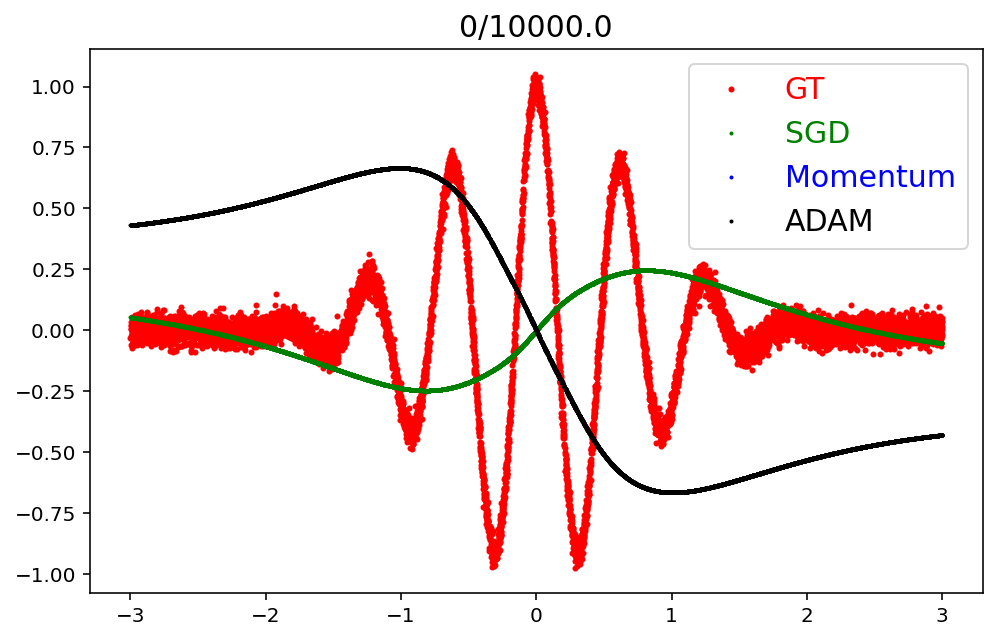

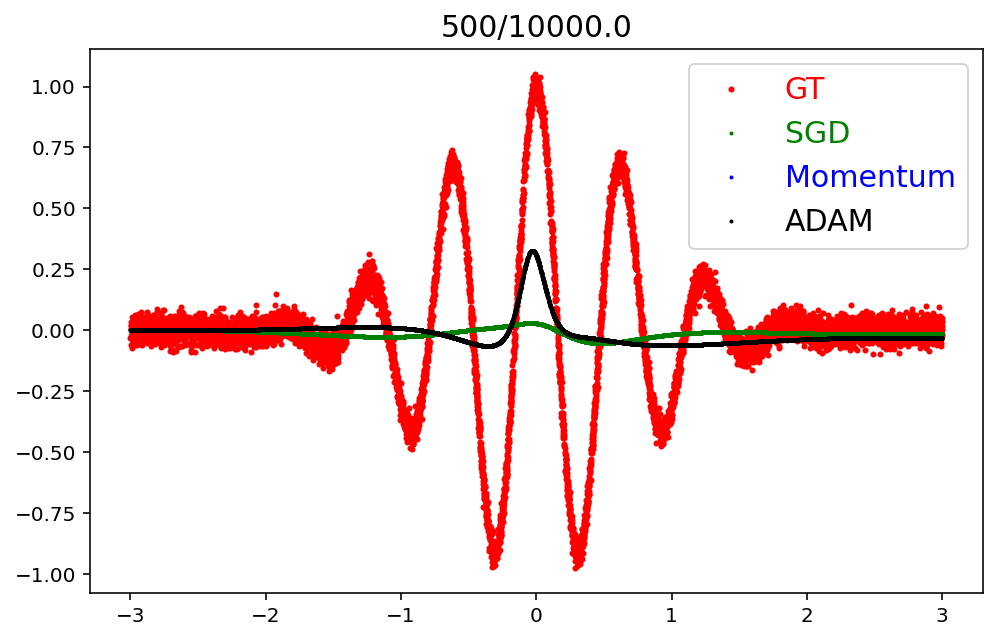

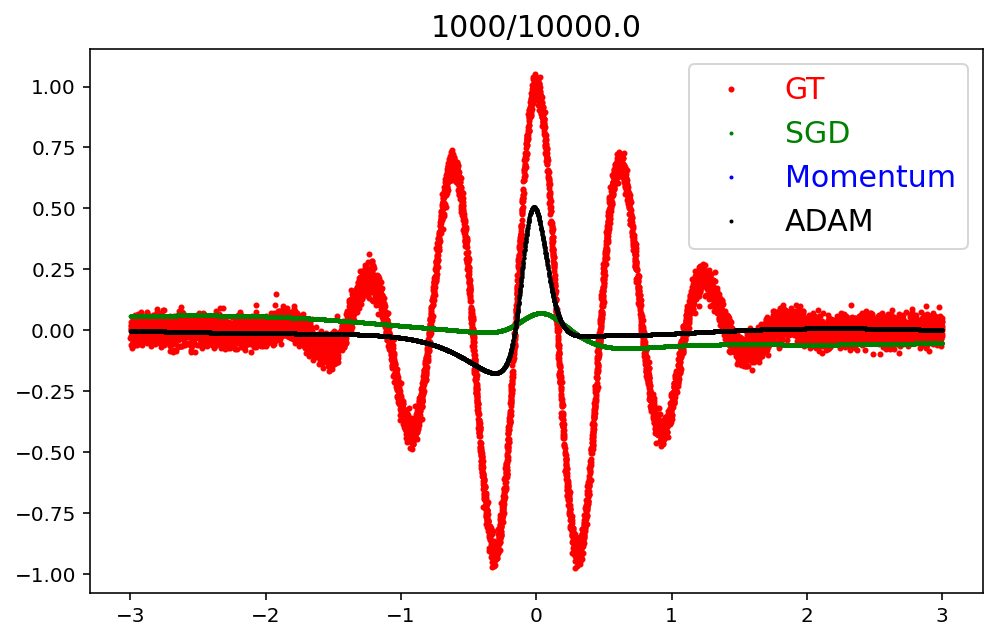

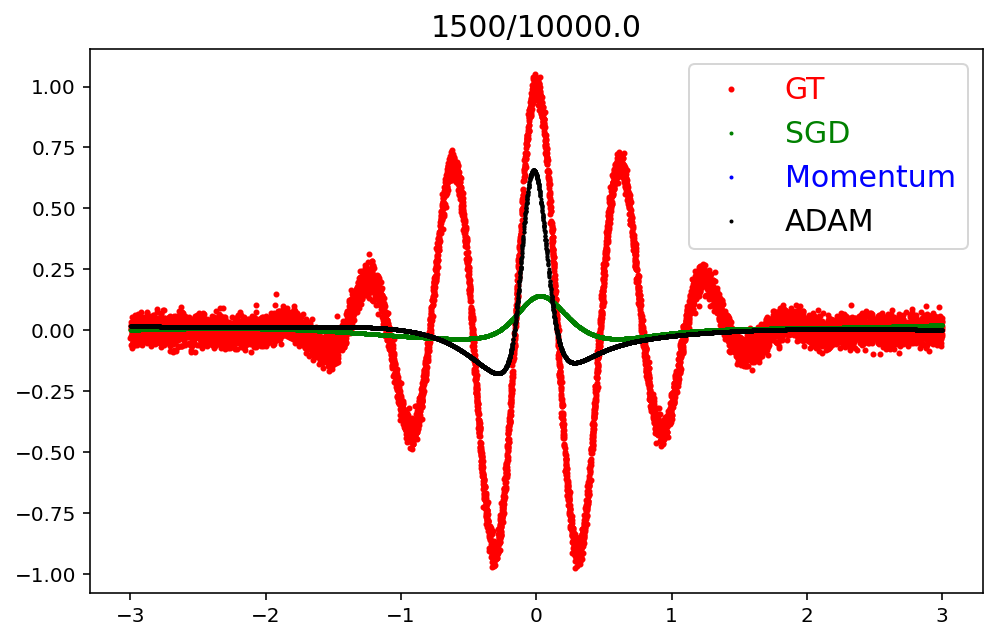

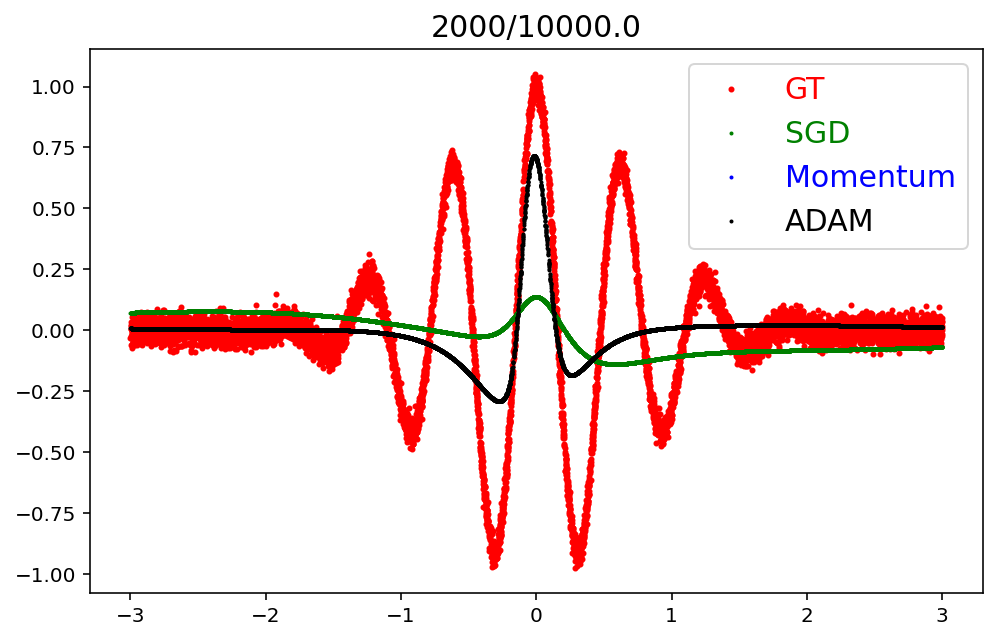

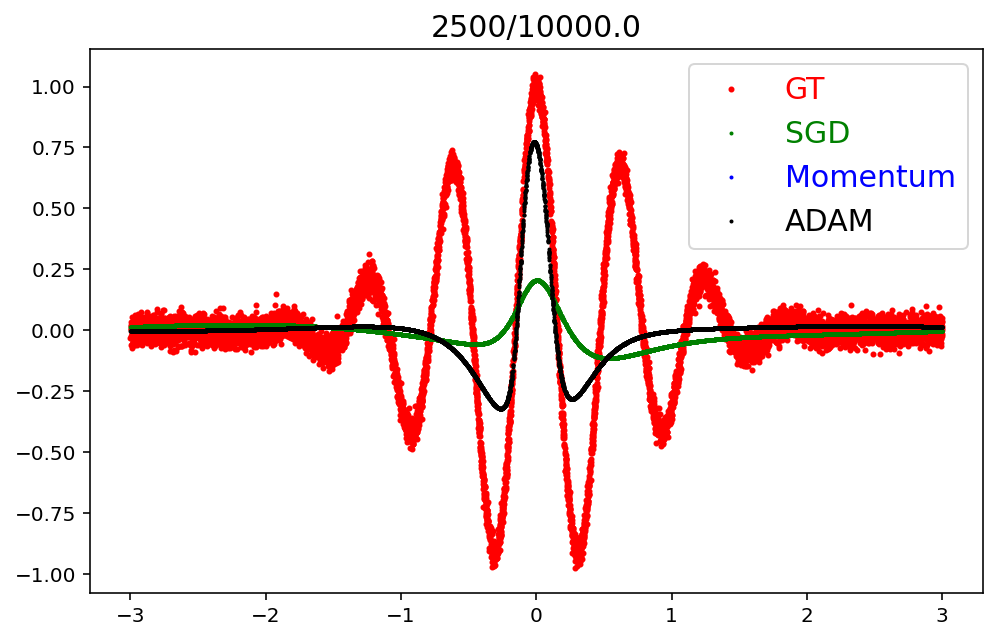

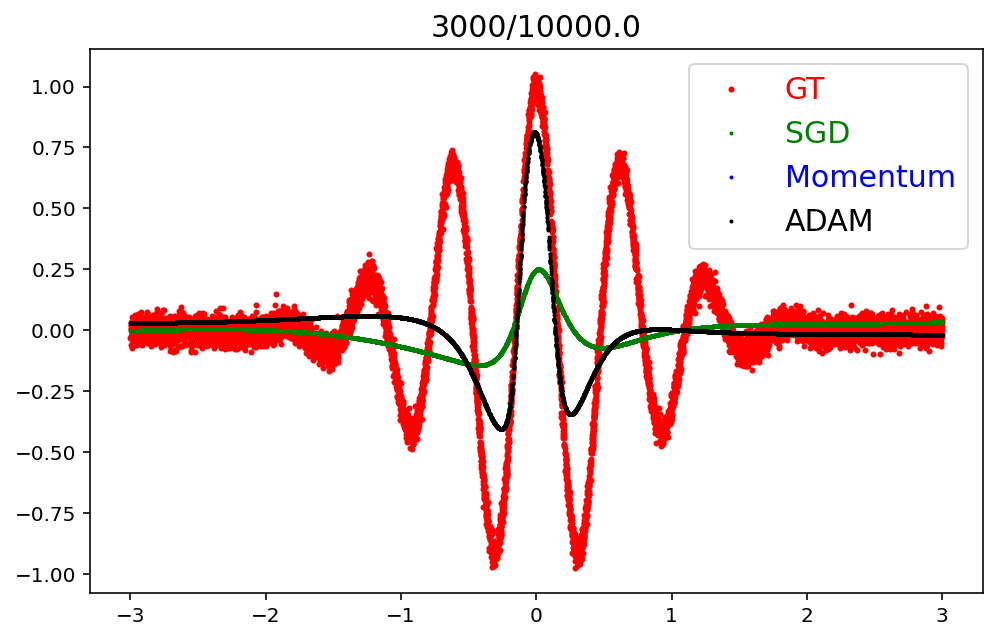

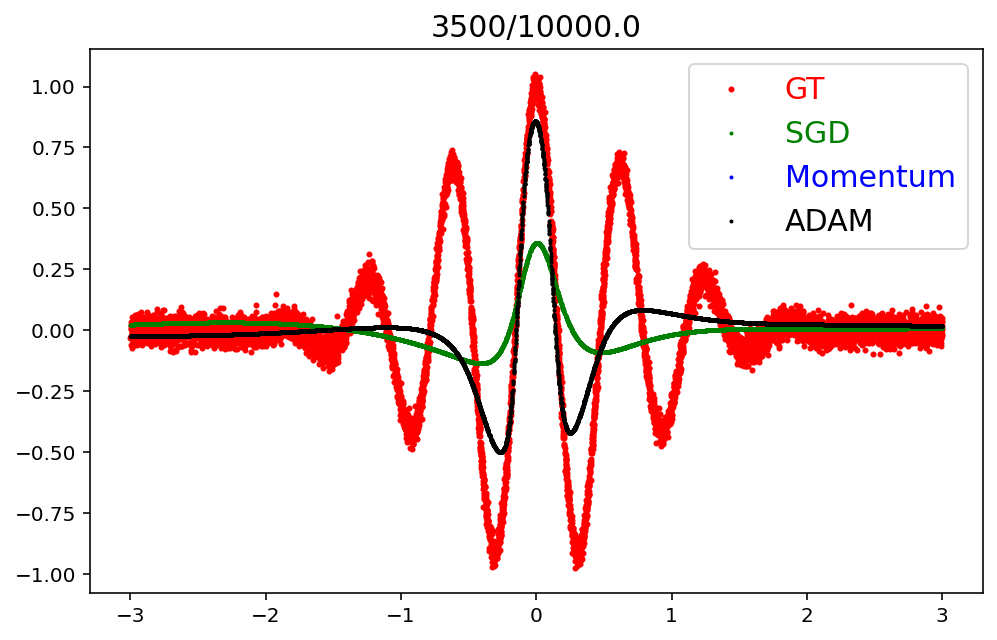

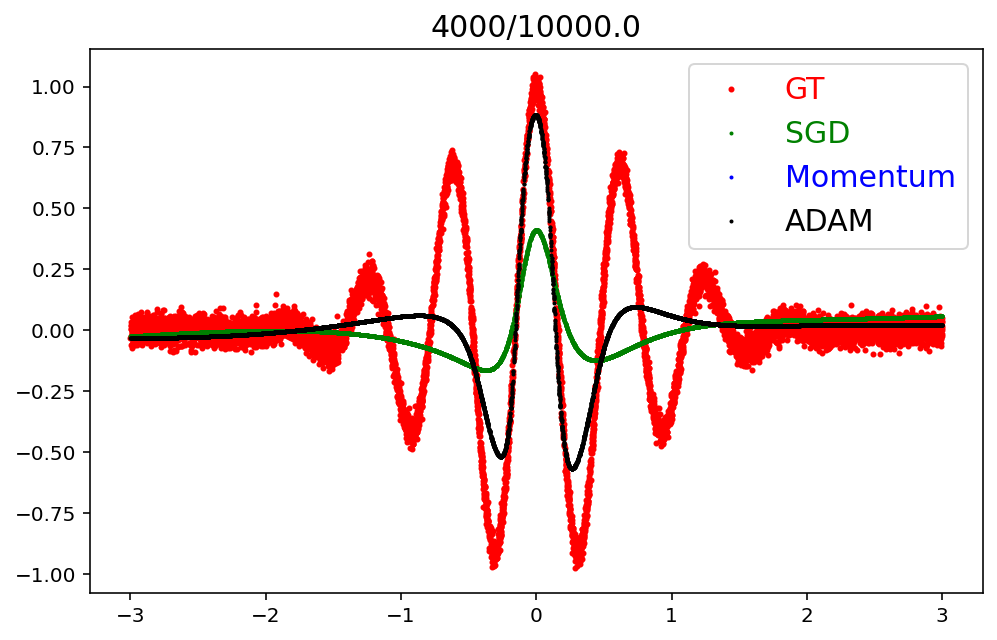

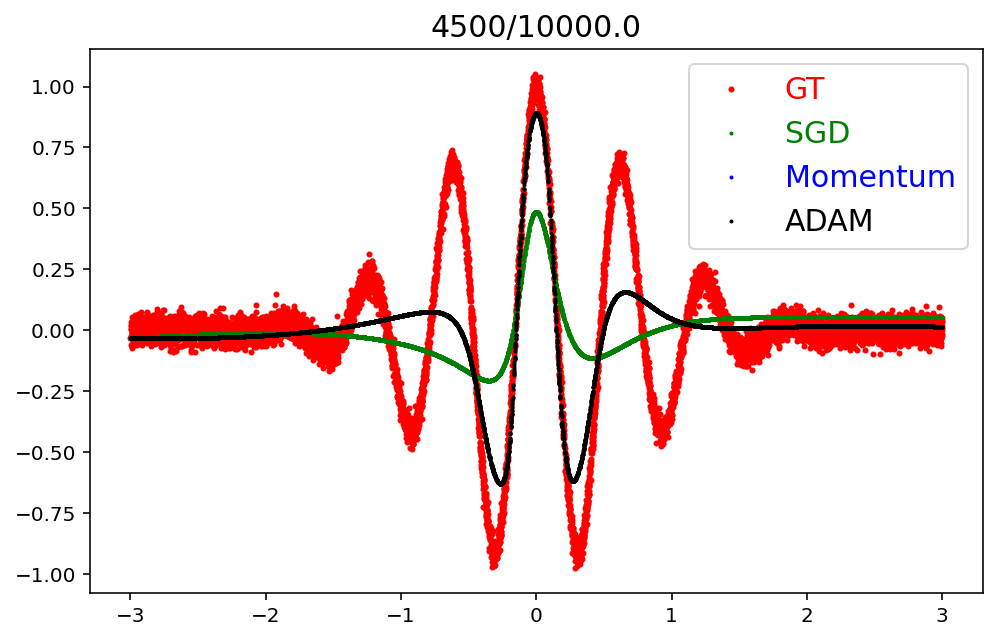

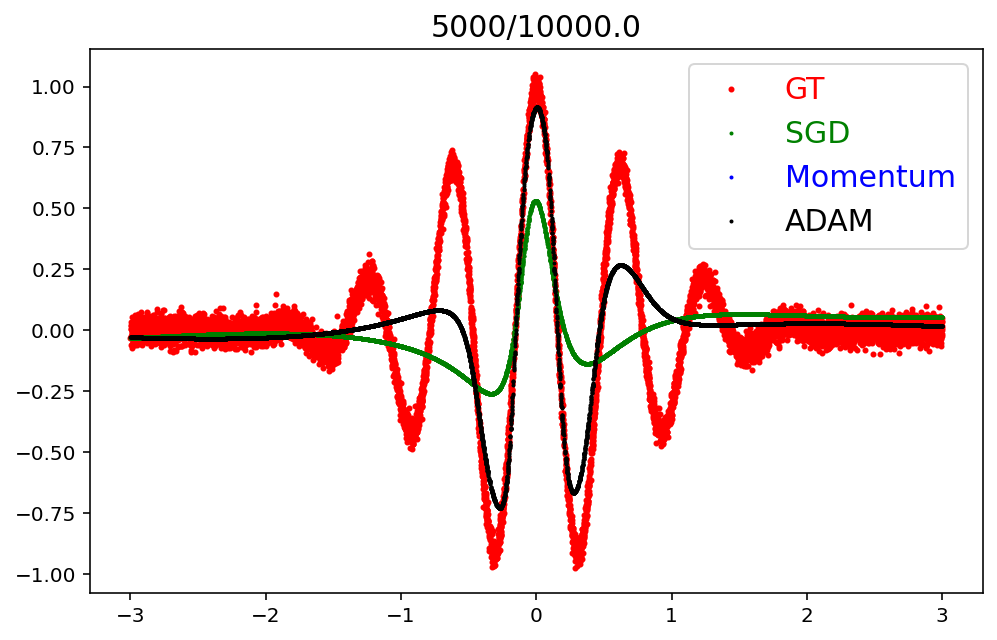

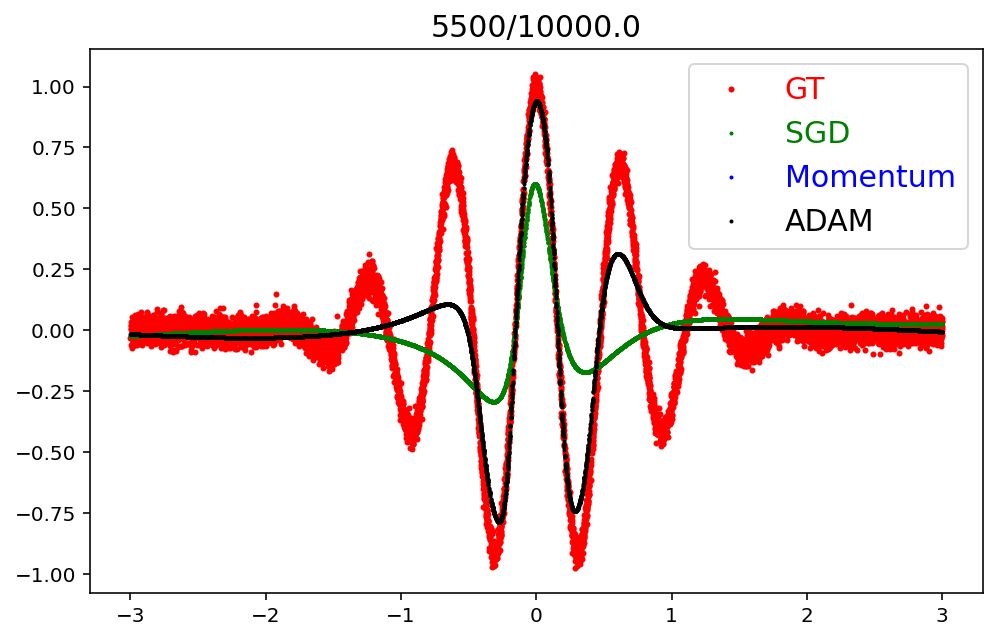

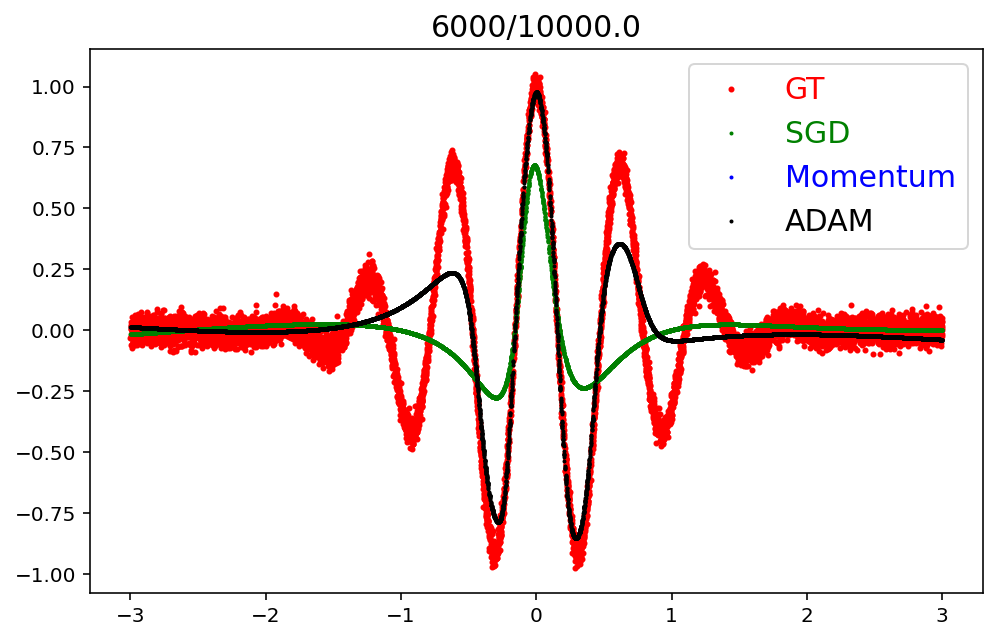

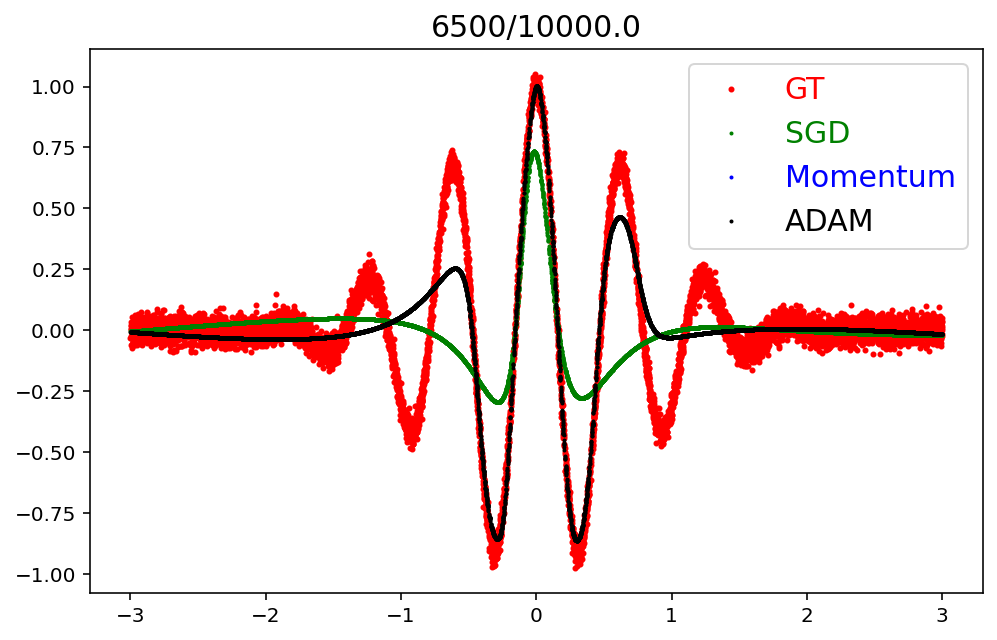

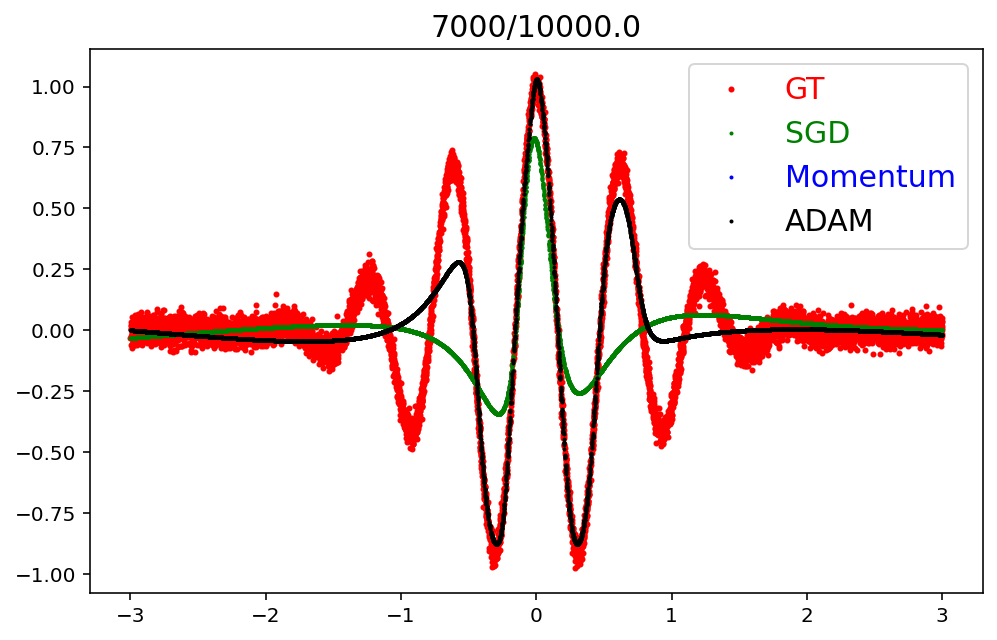

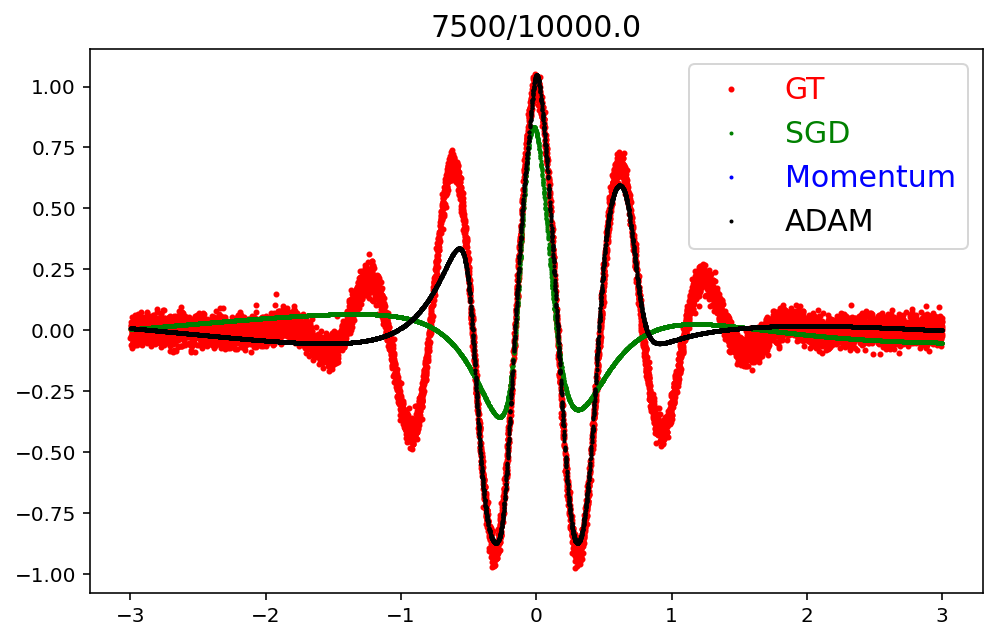

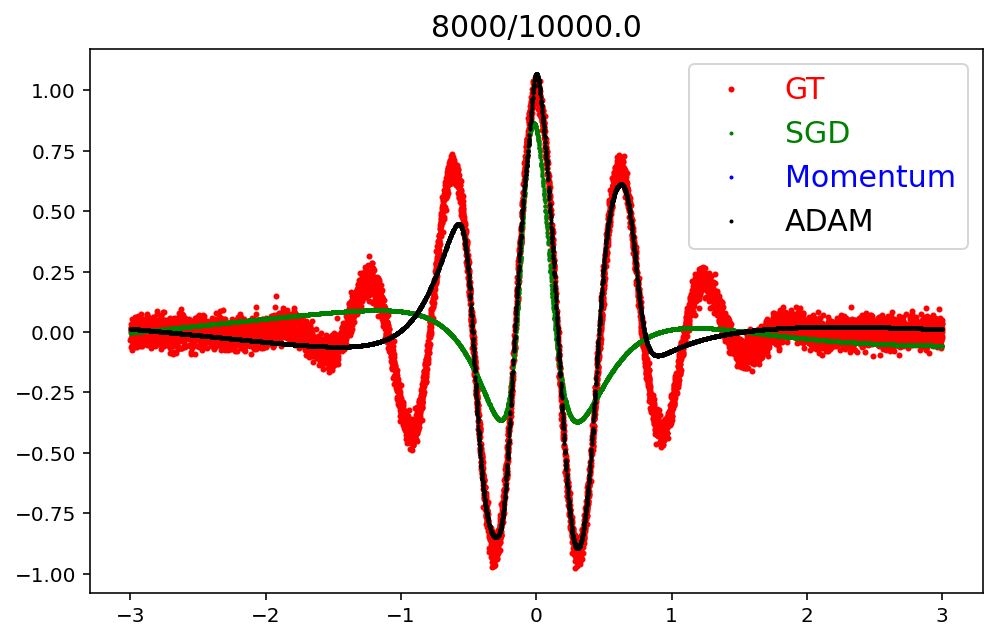

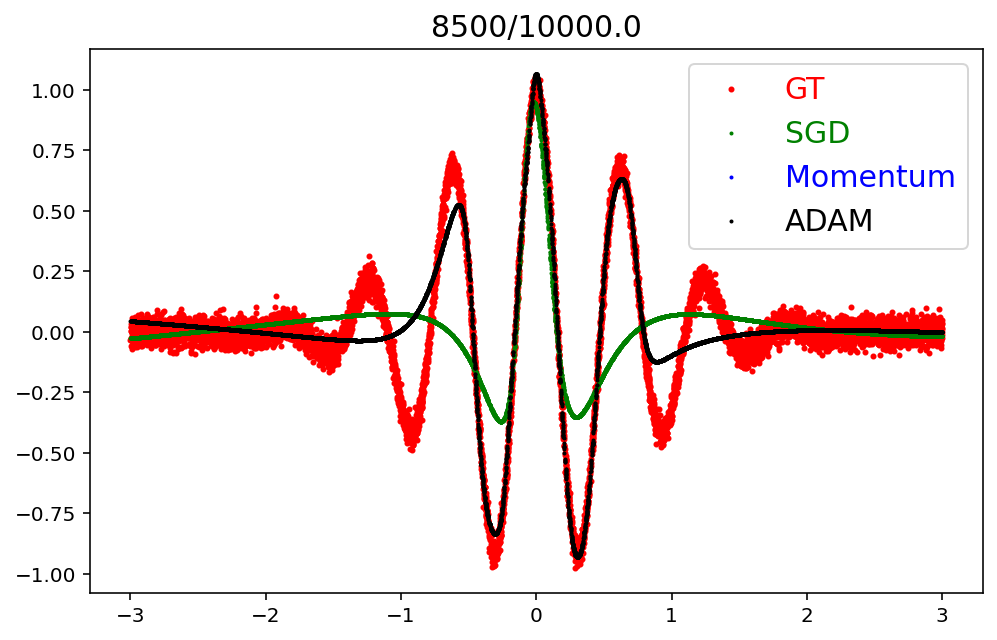

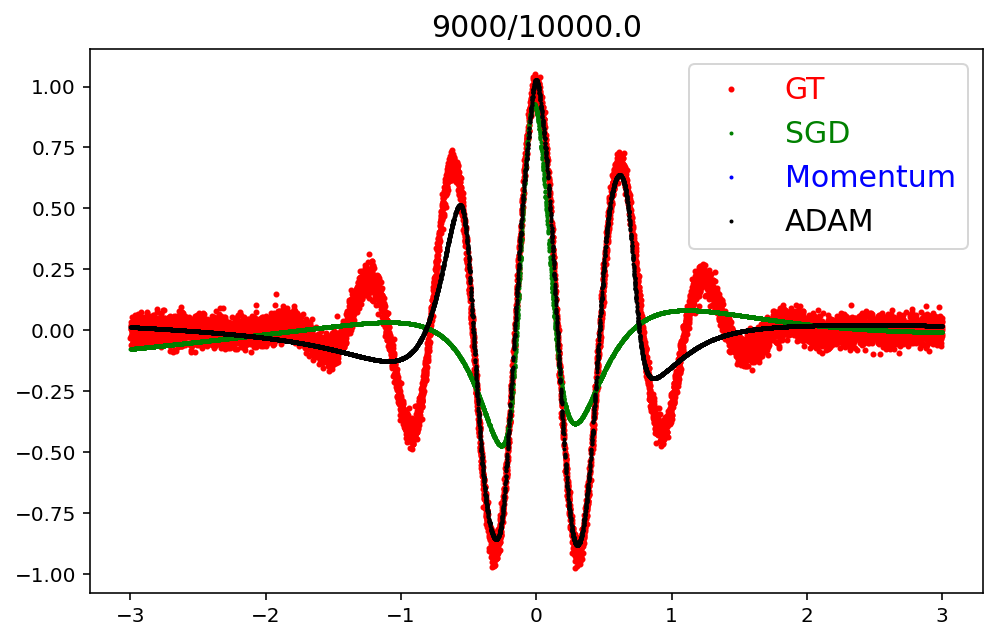

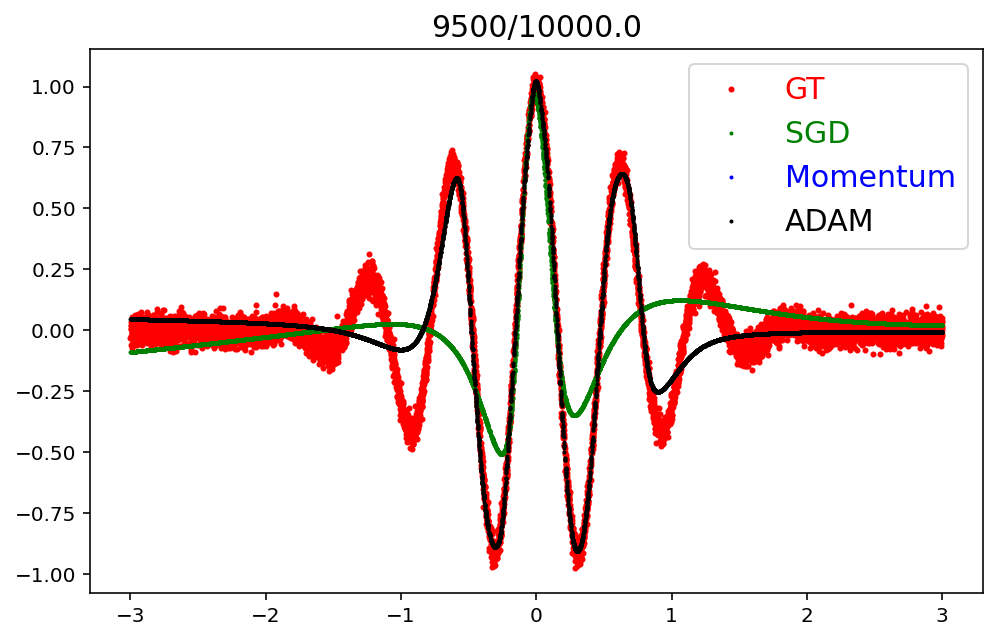

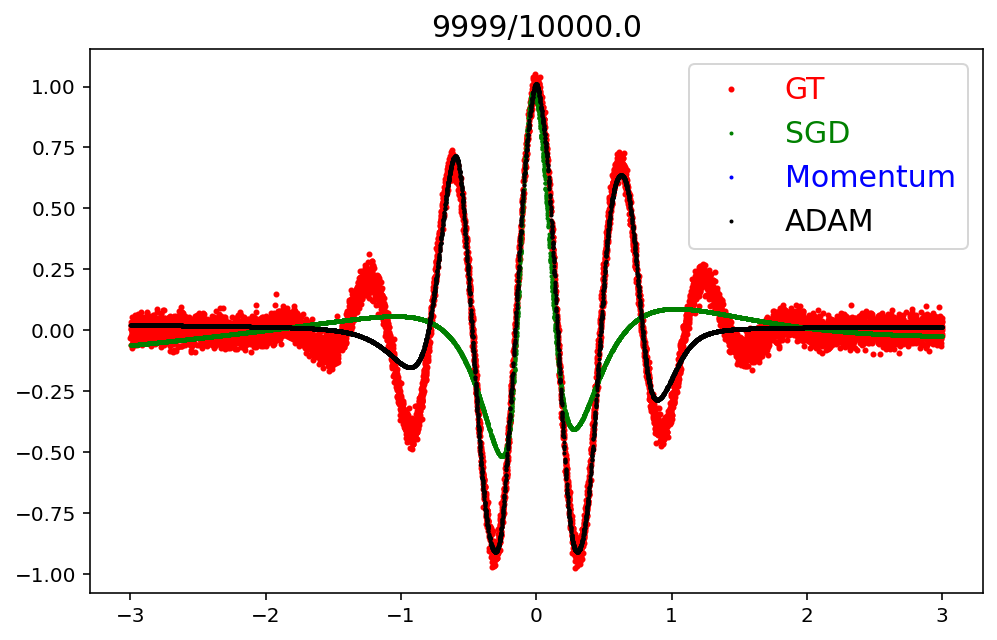

Done.


In [10]:
MAX_ITER, BATCH_SIZE, PLOT_EVERY = 1e4, 64, 500

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train()
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)):
  # np.random.permutation([1, 4, 9, 12, 15])
  # >>> array([15,  1,  9,  4, 12]) # random
  # np.random.permutation(10)
  # >>> array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6]) # random
  r_idx = np.random.permutation(n_data)[:BATCH_SIZE]
  batch_x, batch_y = x_torch[r_idx], y_torch[r_idx]

  # Update With Adam
  y_pred_adam = model_adam.forward(batch_x)
  loss_adam = loss(y_pred_adam, batch_y)
  optm_adam.zero_grad()
  loss_adam.backward()
  optm_adam.step()

  # Update With Momentum
  y_pred_momentum = model_momentum.forward(batch_x)
  loss_momentum = loss(y_pred_momentum, batch_y)
  optm_momentum.zero_grad()
  loss_momentum.backward()
  optm_momentum.step()

  # Update With SGD
  y_pred_sgd = model_sgd.forward(batch_x)
  loss_sgd = loss(y_pred_sgd, batch_y)
  optm_sgd.zero_grad()
  loss_sgd.backward()
  optm_sgd.step()

  if ((it%PLOT_EVERY) == 0) or (it == 0) or (it == (MAX_ITER-1)):
    with torch.no_grad():
      y_sgd_numpy = model_sgd.forward(x_torch).detach().cpu().numpy()
      y_momentum_numpy = model_momentum.forward(x_torch).detach().cpu().numpy()
      y_adam_numpy = model_adam.forward(x_torch).detach().cpu().numpy()

      plt.figure(figsize = (8,5))
      plt.plot(x_numpy,y_numpy,'r.',ms=4,label='GT')
      plt.plot(x_numpy,y_sgd_numpy,'g.',ms=2,label='SGD')
      plt.plot(x_numpy,y_momentum_numpy,'b.',ms=2,label='Momentum')
      plt.plot(x_numpy,y_adam_numpy,'k.',ms=2,label='ADAM')
      plt.title(f"{it}/{MAX_ITER}", fontsize = 15)
      plt.legend(labelcolor = 'linecolor', loc = 'upper right', fontsize = 15)
      plt.show()

print("Done.")